## Barren Plateau Problems

In [2]:
import qiskit as qk
from qiskit import Aer, QuantumCircuit

from qiskit.circuit import Parameter, ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigen_solvers.vqe import VQEResult
from qiskit.algorithms.optimizers import COBYLA
from typing import Tuple, List, Dict, Union
from scipy.optimize import minimize, OptimizeResult
import numpy as np
from random import random
import json
from pprint import pprint
import matplotlib.pyplot as plt
from operator import truediv
from cmath import pi
from random import randint
import os
%matplotlib inline

MUB_CIRC_2_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '2_302')
MUB_CIRC_3_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '3_306')

N_QUBIT_NO_MUB_PATH = 'no_mub_results_n.txt'
NO_MUB_PATH = 'no_mub_results_3.txt'
PRE_MUB_PATH = 'prepend_mub_results_3.txt'
APP_MUB_PATH = 'append_mub_results.txt'

NO_MUB_GRAPH_FOLDER = '3 qubit graphs'
N_QUBIT_NO_MUB_GRAPH_FOLDER = 'n qubit graphs'

VQC_FOLDER = 'VQC results'

EPS_TOL = 1e-12
LO_TOL = 1e-5
HI_TOL = 0.2
LO_CORR_THRESHOLD = 0.1
HI_CORR_THRESHOLD = 0.4
N_QUBITS = 3

SHOTS = 8192
MAX_ITER = 1e8
qasm_backend = Aer.get_backend('qasm_simulator')
qasm_qi = QuantumInstance(qasm_backend, shots=SHOTS)

### Basic Barren Plateau Circuit for Variational Quantum Compilation

The "Cerezo" ansatz circuit is taken from "Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits" by Cerezo et al., 2021, Figure 4.
The "Arrasmith" ansatz circuit is taken from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

The attempted task is "trivial" Variational Quantum Compilation.
Vartational Quantum Compilation gets some unitary $U$, and an ansatz $V(\theta)$, and attempts to find a value for $\theta$ such that $V(\theta)| 0 \rangle = U | 0 \rangle$.

In this case, we choose $U=I$.
Because we pick a *random* initial guess for $\theta$, we will experience the barren plateaus that occur when the $\theta$ values are away from the target.

Note, however, an important observation:
In order to actually use the "value" of the different MUB starting points, the original value of the parameters needs to be constant (although random) for all experiments.

I took this specific problem from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

In [3]:
def gen_vqc_ansatz_arrasmith(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)
    count=1
    for _ in range(n_layers):
        
        # First layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        # First layer of even CXs
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            
        # Second layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        for i in range(1, n_qubits, 2):
            qc.cx(i, (i+1)%n_qubits)
            
    qc.measure_all()
        
    return qc


### Experimenting without MUBs

#### Experiment Functions

In [4]:
def low_constraint(x: List[float]):
    return min(x)

def hi_constraint(x: List[float]):
    return 2*pi-max(x)

def get_constraints() -> List[dict]:
    return [{'type': 'ineq', 'fun': low_constraint}, {'type': 'ineq', 'fun': hi_constraint}]


# Returns the number of function evaluations it took for the method to converge.
# If during the optimization, the cost function goes below a specified bound, the optimization halts.
# If the optimization halted because of the bound, the OptimizeResult is replaced with None.
def run_vqc_exp(qc: QuantumCircuit, theta0: List[float], tol: float = HI_TOL, success_bound: float=0,
                optimizer: str = 'COBYLA', qi: QuantumInstance = qasm_qi) -> Tuple[List[float], OptimizeResult]:
    class BoundHitException(Exception):
        pass
    
    cost_points = []
    cost_grad = []
    def get_val_from_theta(theta: List[float]) -> float:
        cost_grad.append(theta)
        if float('inf') in theta or float('-inf') in theta:
            print(f'inf bug reached in iteration {len(cost_grad)}.')
            print('printing 99 last cost points:')
            print(cost_points[-99:])
            print('printing 100 last gradient values:')
            print(cost_grad[-100:])
            raise ZeroDivisionError()
        # if len(cost_points) % 100 == 0 or min(theta) < -0.5 or max(theta) > 2*pi:
        #     print(f'{len(cost_points)}: {theta}')
        concrete_qc = qc.bind_parameters(theta)
        results = qi.execute(concrete_qc)
        resval = 1 - (results.get_counts().int_raw.get(0, 0) / SHOTS)
        cost_points.append(resval)
        if (resval) <= success_bound:
            print('WOOP')
            raise BoundHitException()
        return resval

    try:
        if optimizer == 'COBYLA':
            res = minimize(get_val_from_theta,
                theta0,
                method='COBYLA',
                options={'maxiter': MAX_ITER},
                tol=tol,
                constraints=get_constraints())
        else:
            assert optimizer == 'Nelder-Mead'
            res = minimize(get_val_from_theta,
            theta0,
            method='Nelder-Mead',
            options={'maxiter': MAX_ITER},
            tol=tol,
            bounds = [(0,2*pi) for _ in range(len(theta0))])
        
    except BoundHitException:
        return cost_points, True
    except ZeroDivisionError:
        return cost_points, cost_grad
    except KeyboardInterrupt:
        print('Optimization stopped by keyboard interrupt. WOLOLO')
        return cost_points, False

    return cost_points, res



#### Experiments

### 3-qubit, n-layer experiments

In [6]:
no_mub_res = {}
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    theta0 = [np.random.random() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, EPS_TOL, success_bound=HI_CORR_THRESHOLD)

    no_mub_res[n_layers] = layer_res

RUNNING EXPERIMENT FOR 4 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 5 LAYERS:
Optimization stopped by keyboard interrupt. WOLOLO
RUNNING EXPERIMENT FOR 6 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 7 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 8 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 9 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 10 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 11 LAYERS:
Optimization stopped by keyboard interrupt. WOLOLO
RUNNING EXPERIMENT FOR 12 LAYERS:
WOOP


### n-qubit, n-layer experiments

In [5]:
n_qubit_no_mub_res = {}
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(n_layers, n_layers)
    theta0 = [np.random.random() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, EPS_TOL, success_bound=HI_CORR_THRESHOLD)

    n_qubit_no_mub_res[n_layers] = layer_res
    
    if layer_res[1] == False: # Signifying keyboard interrupt
        break
    elif layer_res[1] == True:
        layer_res = (layer_res[0], [])

RUNNING EXPERIMENT FOR 4 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 5 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 6 LAYERS:
WOOP
RUNNING EXPERIMENT FOR 7 LAYERS:
RUNNING EXPERIMENT FOR 8 LAYERS:
RUNNING EXPERIMENT FOR 9 LAYERS:


### Analysis Functions

In [15]:
def avg(col):
    return sum(col) / len(col) if len(col) > 0 else None

def wavg(col, weights):
    assert len(col) == len(weights)
    return sum([v * w for v,w in zip(col, weights)])


def nfev(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return len(evals)
    elif type(record) == VQEResult:
        return record.cost_function_evals
    else:
        assert type(record) == OptimizeResult
        return record.nfev
    
    
def fin_val(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return evals[-1]
    elif type(record) == VQEResult:
        return record.eigenvalue
    else:
        return record.fun


def gen_statistics_nomub(results_dict: Dict[int, Tuple[List[float], VQEResult]],
                         target_vals: List[float] = [],
                         stats_filename: str = NO_MUB_PATH,
                         graph_folder: str = NO_MUB_GRAPH_FOLDER):
    
    res = {l: {'nfev': nfev(res), 'fin_val': fin_val(res), 'evals': res[0]} for l, res in results_dict.items()}
    with open(stats_filename, 'w') as f:
        pprint(res, f)
        
    for l, data in results_dict.items():
        evals, result = data
        plt.axis([0, len(evals), 0, 1])
        plt.plot(evals)
        plt.title(f'Convergence graph with {l} layers')
        
        if target_vals != []:
            plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='red')
        for fake_target in target_vals[1:]:
            plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='purple')
            
        plt.show()
        plt.savefig(os.path.join(graph_folder, f'{l}.png'))
        
    plt.yscale('log')
    plt.plot(results_dict.keys(), [nfev(v) for v in results_dict.values()])
    plt.title('# of function evals from layer no.')
    plt.show()
    plt.savefig(os.path.join(graph_folder, f'nfev_from_layer.png'))
        
    return res

#### Analysis

In [1]:
stats_filename = os.path.join(os.getcwd(), VQC_FOLDER, NO_MUB_PATH)
graph_folder = os.path.join(os.getcwd(), VQC_FOLDER, NO_MUB_GRAPH_FOLDER)
no_mub_stats = gen_statistics_nomub(no_mub_res, stats_filename=stats_filename, graph_folder=graph_folder)

stats_filename = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_PATH)
graph_folder = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_GRAPH_FOLDER)
n_qubit_no_mub_stats = gen_statistics_nomub(n_qubit_no_mub_res, stats_filename=stats_filename, graph_folder=graph_folder)

NameError: name 'VQC_FOLDER' is not defined

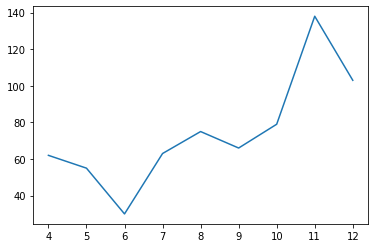

In [85]:
plt.plot(n_qubit_no_mub_stats.keys(), [v['nfev'] for v in n_qubit_no_mub_stats.values()])
plt.show()

## Basic Barren Plateau Circuit for Transverse Ising VQE
To save myself some time, I'll just use the built-in VQE module.

In [108]:
def build_pauli_string(n_qubits: int, mat_locations: Dict[int, str]) -> str:
    assert n_qubits > 0
    H = ''
    for i in range(n_qubits):
        H += mat_locations.get(i, 'I')
    return H

def generate_transverse_ising_ham(n_qubits: int) -> PauliSumOp:
    # Build Individual X strings
    string_list = [(build_pauli_string(n_qubits, {i: 'X'}), random()) for i in range(n_qubits)]
    for i in range(n_qubits):
        string_list += [(build_pauli_string(n_qubits, {i: 'Z', j: 'Z'}), random()) for j in range(i+1, n_qubits)]
    return PauliSumOp.from_list(string_list, 1)

In [105]:
## For now, I'm using the standard qiskit hardware efficient ansatz (as Dekel suggested).
def gen_hardware_eff_ansatz(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    ansatz = EfficientSU2(n_qubits, reps=n_layers, entanglement='linear')
    qc.compose(ansatz, inplace=True)
    return qc

### Experimenting without MUBs

#### Experiment Functions

In [106]:
# Returns the number of function evaluations it took for the method to converge.
def run_vqe_exp(ansatz: QuantumCircuit, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = HI_TOL) -> Tuple[List[float], VQEResult]:
    cost_points = []
    
    def callback(nfev: int, params: np.ndarray, mean: float, std_dev: float):
        cost_points.append(mean)
        
    
    optimizer = COBYLA(maxiter=MAX_ITER, tol=tol)
    vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=qi, initial_point=np.asarray(theta0), callback=callback)
    result = vqe.compute_minimum_eigenvalue(operator=ham)
    return cost_points, result

#### Experiments

In [109]:
no_mub_res_vqe = {}

for n_layers in range(4, 13):
    print(f'RUNNING VQE EXPERIMENT FOR {n_layers} LAYERS:')
    # n_qubits = n_layers
    ham = generate_transverse_ising_ham(N_QUBITS)
    ansatz = gen_hardware_eff_ansatz(N_QUBITS, n_layers)
#     theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    theta0 = [0 for _ in range(ansatz.num_parameters)]
    layer_res = run_vqe_exp(ansatz, ham, theta0=theta0, tol=LO_TOL)
    no_mub_res_vqe[n_layers] = layer_res

RUNNING VQE EXPERIMENT FOR 4 LAYERS:
RUNNING VQE EXPERIMENT FOR 5 LAYERS:
RUNNING VQE EXPERIMENT FOR 6 LAYERS:
RUNNING VQE EXPERIMENT FOR 7 LAYERS:
RUNNING VQE EXPERIMENT FOR 8 LAYERS:
RUNNING VQE EXPERIMENT FOR 9 LAYERS:
RUNNING VQE EXPERIMENT FOR 10 LAYERS:
RUNNING VQE EXPERIMENT FOR 11 LAYERS:
RUNNING VQE EXPERIMENT FOR 12 LAYERS:


In [110]:
eigen_values, eigen_vectors = np.linalg.eigh(ham.to_matrix())

In [67]:
exact_result = eigen_values[0]
print(f"The exact result is: {exact_result}")
print(f"The excited states are: {eigen_values[1:]}")

The exact result is: -2.611073908575124
The excited states are: [-1.75710396 -0.76553487 -0.13554306  0.18934452  0.5137937   1.90793569
  2.65818189]


#### Analysis

In [102]:
# calculate the error from the exact result
for i in range(4, 13):
    print("Error for layer number " + str(i) +": " + str(abs(no_mub_res_vqe[i].eigenvalue - exact_result)))

Error for layer number 4: 0.24741949013293674
Error for layer number 5: 0.42165700401507644
Error for layer number 6: 0.6261742020762586
Error for layer number 7: 0.4706022584405041
Error for layer number 8: 0.21401529415827358
Error for layer number 9: 1.1897460560061148
Error for layer number 10: 0.36511685386935877
Error for layer number 11: 0.055285308974512226
Error for layer number 12: 0.1638953533226779


In [ ]:
filename = os.path.join(os.getcwd(), 'VQE results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub(no_mub_res_vqe, filename=filename)
print(no_mub_stats)
myplot_heatmap([layer['fin_val'] for layer in no_mub_stats.values()], exact_result, eigen_values[1:])
